# Clustering and Viz Experimentation

In [125]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools
import os
import sys

module_path = os.path.abspath(os.path.join('rcnn/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression,Lasso

In [17]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

### importing datasets

In [21]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')

class_dict = util.indexed_dictionary

tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']
#tiles['028012'] = ['20110831']
#tiles['029011'] = ['20110831']
#tiles['028011'] = ['20110831']
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets
    
tile_size = 5
tile_list = ['028012', '029011', '028011']
class_count = len(class_dict)
clean_pixels_count = 3000000
max_count_per_class = 600

### Training Data 

In [ ]:
sk_data, sk_labels, class_count_dict = rnn_pixels.balanced_pix_data(landsat_datasets, lc_labels, canopy_labels, tile_size, tile_list, 
                           clean_pixels_count, class_count, max_count_per_class, class_dict, buffer_pix=1)

sk_data.shape, sk_labels.shape, class_count_dict

Beginning balanced data creation.


### Testing Data

In [58]:
clean_pixels_count_test = 100000
max_count_per_class = 100

sk_data_test, sk_labels_test, class_count_dict_test = rnn_pixels.balanced_pix_data(landsat_datasets, lc_labels, canopy_labels, tile_size, tile_list, 
                           clean_pixels_count_test, class_count, max_count_per_class, class_dict, buffer_pix=1)

sk_data_test.shape, sk_labels_test.shape, class_count_dict_test

Beginning balanced data creation.
Clean pix generated, starting generator.
Iterating through data and clipping for balance.
34438
Processing Complete.


((541, 28), (541, 2), {0: 100, 1: 100, 2: 100, 3: 100, 4: 41, 5: 100})

In [5]:
class_dict

{0: 'Water',
 1: 'Developed',
 2: 'Forest',
 3: 'Cultivated',
 4: 'Barren',
 5: 'Wetland'}

In [64]:
# Data
landcover_train = sk_labels_train[:,0]
canopy_train = sk_labels_train[:,1]
tiles_train = sk_data_train
tiles_test = sk_data_test
landcover_test = sk_labels_test[:,0]
canopy_test = sk_labels_test[:,1]

[array([[0.]]) array([[0.]]) array([[0.98]]) ... array([[0.]])
 array([[0.]]) array([[0.57]])]


## Testing Input Size

In [112]:


# clean_pixels_count_train = 2000000

# max_count_per = []
# class_count_dict_array = []
# scores = []
# for x in range(10,500,10):
#     max_count_per.append(x)
#     sk_data_train, sk_labels_train, class_count_dict_train = rnn_pixels.balanced_pix_data(landsat_datasets, lc_labels, canopy_labels, tile_size, tile_list, 
#                            clean_pixels_count_train, class_count, x, class_dict, buffer_pix=1)
#     class_count_dict_array.append(class_count_dict_train)
    
#     # Data
#     landcover_train = sk_labels_train[:,0]
#     canopy_train = sk_labels_train[:,1]
#     tiles_train = sk_data_train
#     tiles_test = sk_data_test
#     landcover_test = sk_labels_test[:,0]
#     canopy_test = sk_labels_test[:,1]
    
#     # Model
#     clf = svm.SVC()
#     clf.fit(tiles_train,landcover_train.astype('int'))
#     pred_clf = clf.predict(tiles_test)
#     scores.append(accuracy_score(landcover_test.astype('int'),pred_clf))

Beginning balanced data creation.
Clean pix generated, starting generator.
Iterating through data and clipping for balance.
690979
Processing Complete.


AttributeError: 'dict' object has no attribute 'append'

## SVM (Landcover)

In [63]:
#SVM
clf = svm.SVC()
clf.fit(tiles_train,landcover_train.astype('int'))
pred_clf = clf.predict(tiles_test)
print('Classification Report')
print(classification_report(landcover_test.astype('int'), pred_clf))
print('Confusion Matrix')
print(confusion_matrix(landcover_test.astype('int'), pred_clf))

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       100
           1       0.95      0.87      0.91       100
           2       0.93      0.97      0.95       100
           3       0.91      0.93      0.92       100
           4       0.70      0.80      0.75        41
           5       0.93      0.88      0.90       100

    accuracy                           0.92       541
   macro avg       0.90      0.91      0.90       541
weighted avg       0.92      0.92      0.92       541

Confusion Matrix
[[100   0   0   0   0   0]
 [  0  87   0   1  12   0]
 [  0   0  97   0   1   2]
 [  0   1   2  93   0   4]
 [  0   4   1   2  33   1]
 [  1   0   4   6   1  88]]


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## RFC (Landcover)

In [67]:
#RFC
rfc = RandomForestClassifier(n_estimators = 350)
rfc.fit(tiles_train,landcover_train.astype('int'))
pred_rfc = rfc.predict(tiles_test)
print('Classification Report')
print(classification_report(landcover_test.astype('int'), pred_rfc))
print('Confusion Matrix')
print(confusion_matrix(landcover_test.astype('int'), pred_rfc))


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       0.96      0.90      0.93       100
           2       0.95      0.97      0.96       100
           3       0.92      0.94      0.93       100
           4       0.72      0.80      0.76        41
           5       0.93      0.90      0.91       100

    accuracy                           0.93       541
   macro avg       0.91      0.92      0.92       541
weighted avg       0.93      0.93      0.93       541

Confusion Matrix
[[100   0   0   0   0   0]
 [  0  90   0   1   9   0]
 [  0   0  97   0   1   2]
 [  0   0   1  94   2   3]
 [  0   4   0   2  33   2]
 [  0   0   4   5   1  90]]


## KNN (Landcover)

In [68]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 23)
knn.fit(tiles_train,landcover_train.astype('int'))
pred_knn = knn.predict(tiles_test)
print('Classification Report')
print(classification_report(landcover_test.astype('int'), pred_knn))
print('Confusion Matrix')
print(confusion_matrix(landcover_test.astype('int'), pred_knn))

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       100
           1       0.88      0.90      0.89       100
           2       0.92      0.99      0.95       100
           3       0.90      0.85      0.88       100
           4       0.65      0.63      0.64        41
           5       0.88      0.84      0.86       100

    accuracy                           0.89       541
   macro avg       0.87      0.87      0.87       541
weighted avg       0.89      0.89      0.89       541

Confusion Matrix
[[100   0   0   0   0   0]
 [  0  90   0   0  10   0]
 [  0   0  99   0   0   1]
 [  0   2   2  85   3   8]
 [  0  10   1   2  26   2]
 [  2   0   6   7   1  84]]


## Linear Regression (Canopy)

Mean Absolute Error: 0.12693645361245082
Mean Squared Error: 0.029448327042162343
Root Mean Squared Error: 0.17160514864700985


Text(0.5, 1.0, 'Linear Regression')

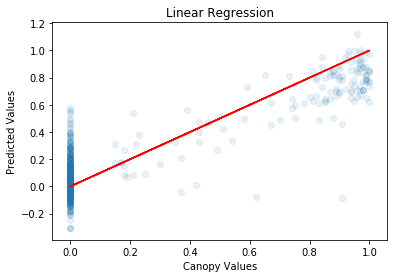

In [124]:
LR = LinearRegression()
LR.fit(tiles_train,canopy_train)
predLR = LR.predict(tiles_test)

print('Mean Absolute Error:',metrics.mean_absolute_error(canopy_test, predLR))
print('Mean Squared Error:',metrics.mean_squared_error(canopy_test, predLR))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(canopy_test,predLR)))

%matplotlib inline 
plt.figure(1);
plt.scatter(canopy_test, predLR, alpha = .1)
plt.plot(canopy_test, canopy_test,color = 'r')
plt.xlabel('Canopy Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression')

## Lasso (Canopy)

Mean Absolute Error: 0.1853649452526745
Mean Squared Error: 0.059990422335287376
Root Mean Squared Error: 0.24492942317183408


Text(0.5, 1.0, 'Lasso')

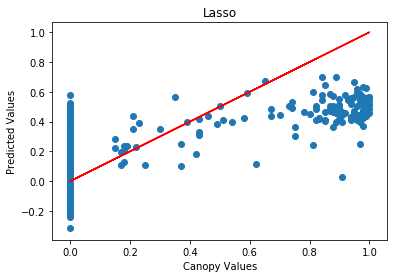

In [128]:
las= Lasso(alpha = 0.05)
las.fit(tiles_train,canopy_train)
predLas = las.predict(tiles_test)


print('Mean Absolute Error:',metrics.mean_absolute_error(canopy_test, predLas))
print('Mean Squared Error:',metrics.mean_squared_error(canopy_test, predLas))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(canopy_test, predLas)))

%matplotlib inline 
plt.figure(1);
plt.scatter(canopy_test, predLas)
plt.plot(canopy_test, canopy_test,color = 'r')
plt.xlabel('Canopy Values')
plt.ylabel('Predicted Values')
plt.title('Lasso')

## Random Forest Regression

Mean Absolute Error: 0.03962292051756008
Mean Squared Error: 0.009371009242144178
Root Mean Squared Error: 0.09680397327663869


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Text(0.5, 1.0, 'Random Forest Regression')

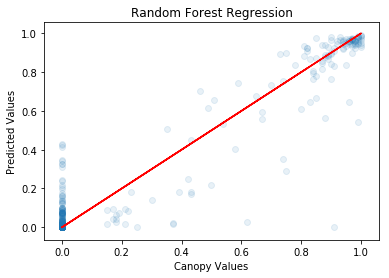

In [135]:
rfr = RandomForestRegressor()
rfr.fit(tiles_train,canopy_train)
pred_rfr = rfr.predict(tiles_test)

print('Mean Absolute Error:',metrics.mean_absolute_error(canopy_test, pred_rfr))
print('Mean Squared Error:',metrics.mean_squared_error(canopy_test, pred_rfr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(canopy_test,pred_rfr)))

%matplotlib inline 
plt.figure(1);
plt.scatter(canopy_test, pred_rfr, alpha = .1)
plt.plot(canopy_test, canopy_test,color = 'r')
plt.xlabel('Canopy Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression')

## Spectral Signatures

Landsat 5 specs from USGS https://www.usgs.gov/land-resources/nli/landsat/landsat-5

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[8,8])

# numbers 1-8
band_count = np.arange(1,29)

for class_index in class_dict:
    band_intensity = np.mean(sk_data[sk_labels==class_index, :], axis=0)
    ax.plot(band_count, band_intensity, label=class_dict[class_index])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


In [ ]:
sk_data.reshape(-1,4,7).shape

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[8,8])

# numbers 1-8
band_count = np.arange(1,8)

for class_index in class_dict:
    # reshape into 4 time steps of 
    time_steps = len(tiles['028012'])
    band_intensity = np.mean(sk_data[sk_labels==class_index, :].reshape(-1,time_steps,7), axis=(0,1))
    ax.plot(band_count, band_intensity, label=class_dict[class_index])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


### Dendrogram

In [ ]:
from scipy.cluster import hierarchy

image_avgs = []    
for class_index in class_dict:
    image_avgs.append(np.mean(sk_data[sk_labels==class_index, :], axis=0))

ytdist = np.array(image_avgs)

Z = hierarchy.linkage(ytdist, 'single')
plt.figure(figsize=(10,10))
dn = hierarchy.dendrogram(Z, labels=list(class_dict.values()))

### PCA and Clustering

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca_result = pca.fit_transform(sk_data)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

df = pd.DataFrame({'pca-one':pca_result[:,0],'pca-two':pca_result[:,1],'pca-three':pca_result[:,2], 'y' : sk_labels})

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", len(np.unique(sk_labels))),
    data=df,
    legend="full",
    alpha=0.3
)

In [ ]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=df["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [ ]:
from time import time
from sklearn.manifold import TSNE

N = 10000
data_subset = sk_data[:N, :]

time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

In [ ]:
df_subset = df.loc[:N-1,:].copy()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", len(np.unique(sk_labels))),
    data=df_subset,
    legend="full",
    alpha=0.3
)